In [1]:
!pip install keras keras-hub --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.9/947.9 kB 56.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.21.1 requires keras-hub==0.21.1, but you have keras-hub 0.22.2 which is incompatible.


In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax" # Or "tensorflow" or "torch"

import keras
from keras import layers
import keras_hub
from keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil
import zipfile
import pandas as pd
import random
import tensorflow as tf

In [3]:
zip_file_path = "/content/cats_vs_dogs_small.zip"

if os.path.exists(zip_file_path):
    print(f"Found {zip_file_path}, now extracting...")
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall("/content/")
    print(" Data extracted successfully.")
else:
    print(f" '{zip_file_path}' not found. Please upload the zipped folder first.")
    raise FileNotFoundError(f"'{zip_file_path}' not found.")

# Define the base directory path after unzipping
base_dir = pathlib.Path("/content/cats_vs_dogs_small")
source_train_dir = base_dir / "train"
source_val_dir = base_dir / "validation"
source_test_dir = base_dir / "test"


if base_dir.exists():
    num_train = len(list(source_train_dir.glob("*/*.jpg")))
    num_val = len(list(source_val_dir.glob("*/*.jpg")))
    num_test = len(list(source_test_dir.glob("*/*.jpg")))
    print(f"\nData verification successful!")
    print(f"  Total original training images found:   {num_train}")
    print(f"  Total original validation images found: {num_val}")
    print(f"  Total original test images found:       {num_test}")
else:
    print(f" Base directory not found at {base_dir}")
    raise FileNotFoundError("Base directory not found after unzipping.")

Found /content/cats_vs_dogs_small.zip, now extracting...
 Data extracted successfully.

Data verification successful!
  Total original training images found:   2000
  Total original validation images found: 1000
  Total original test images found:       1000


In [4]:
def create_experimental_training_set(source_dir, dest_dir, train_size_per_class):

    if dest_dir.exists():
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    for category in ("cats", "dogs"):
        os.makedirs(dest_dir / category, exist_ok=True)
        fnames = [f for f in os.listdir(source_dir / category) if f.endswith('.jpg')]
        random.shuffle(fnames)

        num_to_copy = min(train_size_per_class, len(fnames))
        for i in range(num_to_copy):
            src = source_dir / category / fnames[i]
            dst = dest_dir / category / fnames[i]
            shutil.copyfile(src, dst)
    print(f"Created experimental training set with {num_to_copy} images per class.")

def create_experimental_validation_set(source_dir, dest_dir, val_size_per_class):

    if dest_dir.exists():
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    for category in ("cats", "dogs"):
        os.makedirs(dest_dir / category, exist_ok=True)
        fnames = [f for f in os.listdir(source_dir / category) if f.endswith('.jpg')]
        random.shuffle(fnames)

        num_to_copy = min(val_size_per_class, len(fnames))
        for i in range(num_to_copy):
            src = source_dir / category / fnames[i]
            dst = dest_dir / category / fnames[i]
            shutil.copyfile(src, dst)
    print(f"Created experimental validation set with {num_to_copy} images per class.")

def create_experimental_test_set(source_dir, dest_dir, test_size_per_class):

    if dest_dir.exists():
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    for category in ("cats", "dogs"):
        os.makedirs(dest_dir / category, exist_ok=True)
        fnames = [f for f in os.listdir(source_dir / category) if f.endswith('.jpg')]
        random.shuffle(fnames)

        num_to_copy = min(test_size_per_class, len(fnames))
        for i in range(num_to_copy):
            src = source_dir / category / fnames[i]
            dst = dest_dir / category / fnames[i]
            shutil.copyfile(src, dst)
    print(f"Created experimental test set with {num_to_copy} images per class.")


data_augmentation_layer = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ],
    name="data_augmentation"
)

def build_scratch_model(input_shape=(180, 180, 3), dropout_rate=0.25):
    inputs = keras.Input(shape=input_shape)
    # Augmentation as a layer
    x = data_augmentation_layer(inputs)
    # Rescaling
    x = layers.Rescaling(1.0 / 255)(x)
    # Rest of the model
    x = layers.Conv2D(32, 3, activation="relu")(x); x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation="relu")(x); x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation="relu")(x); x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, activation="relu")(x); x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(512, 3, activation="relu")(x); x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

def build_pretrained_xception_model(trainable_base=False, dropout_rate=0.25, input_shape=(180, 180, 3)):

    try:

        conv_base = keras_hub.models.Backbone.from_preset("xception_41_imagenet", trainable=trainable_base, name="xception_backbone")
        preprocessor = keras_hub.layers.ImageConverter.from_preset("xception_41_imagenet", image_size=(180, 180))

        inputs = keras.Input(shape=input_shape)
        # Apply augmentation first
        x = data_augmentation_layer(inputs)

        x = preprocessor(x)

        x = conv_base(x)
        # Add classification head
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)


        optimizer = keras.optimizers.Adam()
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
        return model, conv_base # Return conv_base for fine-tuning access

    except Exception as e:
        print(f"Error building pretrained Xception model: {e}")

        raise

def train_and_evaluate(model, train_dataset, val_dataset, test_dataset, model_name, epochs=50):
    callbacks = [
        keras.callbacks.ModelCheckpoint(f"{model_name}.keras", save_best_only=True, monitor="val_loss", verbose=0),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1) # Verbose early stopping
    ]
    print(f"Starting training for {model_name}...")
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    )
    print(f"Training finished for {model_name}. Loading best model...")

    try:
        best_model = keras.models.load_model(f"{model_name}.keras")
        print("Best model loaded successfully.")
    except Exception as e:
        print(f"Could not load the best model from {model_name}.keras. Using the model state from the end of training. Error: {e}")
        best_model = model

    print(f"Evaluating {model_name} on test data...")
    test_loss, test_acc = best_model.evaluate(test_dataset, verbose=0)
    print(f"Evaluation complete for {model_name}.")
    return {"history": history.history, "test_loss": test_loss, "test_accuracy": test_acc}

def plot_training_history(history, title):
    if not history:
        print(f"No history data to plot for {title}")
        return
    acc = history.get("accuracy", [])
    val_acc = history.get("val_accuracy", [])
    loss = history.get("loss", [])
    val_loss = history.get("val_loss", [])

    if not acc or not val_acc or not loss or not val_loss:
        print(f"History data is incomplete for {title}. Cannot plot.")
        # print(f"Available keys: {history.keys()}") # Debugging line
        return

    epochs = range(1, len(acc) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(epochs, acc, 'r--', label='Training accuracy'); ax1.plot(epochs, val_acc, 'b-', label='Validation accuracy')
    ax1.set_title(f'{title} - Accuracy'); ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax2.plot(epochs, loss, 'r--', label='Training loss'); ax2.plot(epochs, val_loss, 'b-', label='Validation loss')
    ax2.set_title(f'{title} - Loss'); ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



batch_size = 32
image_size = (180, 180)


val_set_size_per_class = 250
test_set_size_per_class = 250

experimental_val_dir = pathlib.Path(f"experimental_validation_{val_set_size_per_class*2}")
experimental_test_dir = pathlib.Path(f"experimental_test_{test_set_size_per_class*2}")


print("Creating smaller validation and test sets as required by instructions...")
create_experimental_validation_set(source_val_dir, experimental_val_dir, val_set_size_per_class)
create_experimental_test_set(source_test_dir, experimental_test_dir, test_set_size_per_class)


print("\nLoading fixed smaller validation and test datasets...")
validation_dataset = image_dataset_from_directory(
    experimental_val_dir,
    image_size=image_size,
    batch_size=batch_size
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = image_dataset_from_directory(
    experimental_test_dir,
    image_size=image_size,
    batch_size=batch_size
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"\nFixed smaller validation set loaded: {tf.data.experimental.cardinality(validation_dataset)*batch_size} images")
print(f"Fixed smaller test set loaded: {tf.data.experimental.cardinality(test_dataset)*batch_size} images")
print("Fixed smaller validation and test datasets ready.")

Creating smaller validation and test sets as required by instructions...
Created experimental validation set with 250 images per class.
Created experimental test set with 250 images per class.

Loading fixed smaller validation and test datasets...
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.

Fixed smaller validation set loaded: 512 images
Fixed smaller test set loaded: 512 images
Fixed smaller validation and test datasets ready.



==================== Starting Scratch Training with 1000 samples ====================
Training from scratch with an experimental set of 500 samples per class
Created experimental training set with 500 images per class.
Found 1000 files belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,569,089 (5.99 MB)

 Trainable params: 1,569,089 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for scratch_train_500...
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 775ms/step - accuracy: 0.4850 - loss: 0.6981 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.5190 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6881
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 349ms/step - accuracy: 0.5520 - loss: 0.6914 - val_accuracy: 0.5020 - val_loss: 0.6814
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - accuracy: 0.5590 - loss: 0.6808 - val_accuracy: 0.5700 - val_loss: 0.6710
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.5720 - loss: 0.6650 - val_accuracy: 0.5620 - val_loss: 0.6776
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 324ms/step - accuracy: 0.5740 - loss: 0.6609 - val_accuracy: 0.5780 - val_loss: 0.6739
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.5890 - loss: 0.6533 - val_accuracy: 0.5880 - val_loss: 0.6594
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms

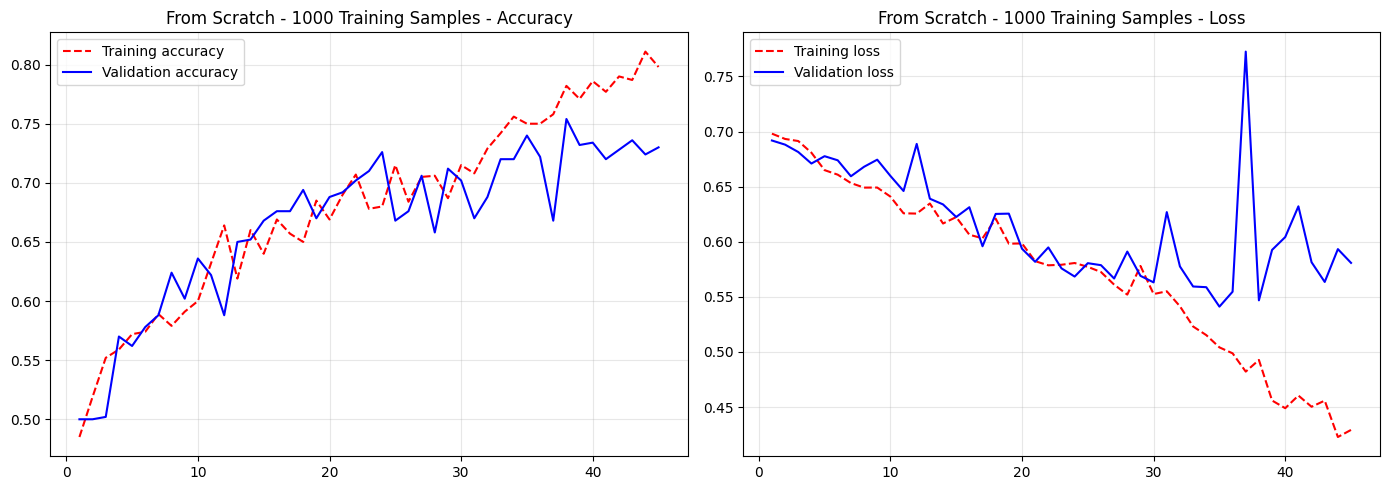


Final Results (Scratch, Train Size 1000): Test Accuracy = 0.7180

==================== Starting Scratch Training with 1500 samples ====================
Training from scratch with an experimental set of 750 samples per class
Created experimental training set with 750 images per class.
Found 1500 files belonging to 2 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,569,089 (5.99 MB)

 Trainable params: 1,569,089 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for scratch_train_750...
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 583ms/step - accuracy: 0.4713 - loss: 0.6950 - val_accuracy: 0.5160 - val_loss: 0.6931
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.4780 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 323ms/step - accuracy: 0.5027 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.5147 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 324ms/step - accuracy: 0.4787 - loss: 0.6933 - val_accuracy: 0.5540 - val_loss: 0.6929
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 333ms/step - accuracy: 0.5080 - loss: 0.6925 - val_accuracy: 0.5060 - val_loss: 0.6858
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 343ms/step - accuracy: 0.5620 - loss: 0.6916 - val_accuracy: 0.5120 - val_loss: 0.6916
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 321m

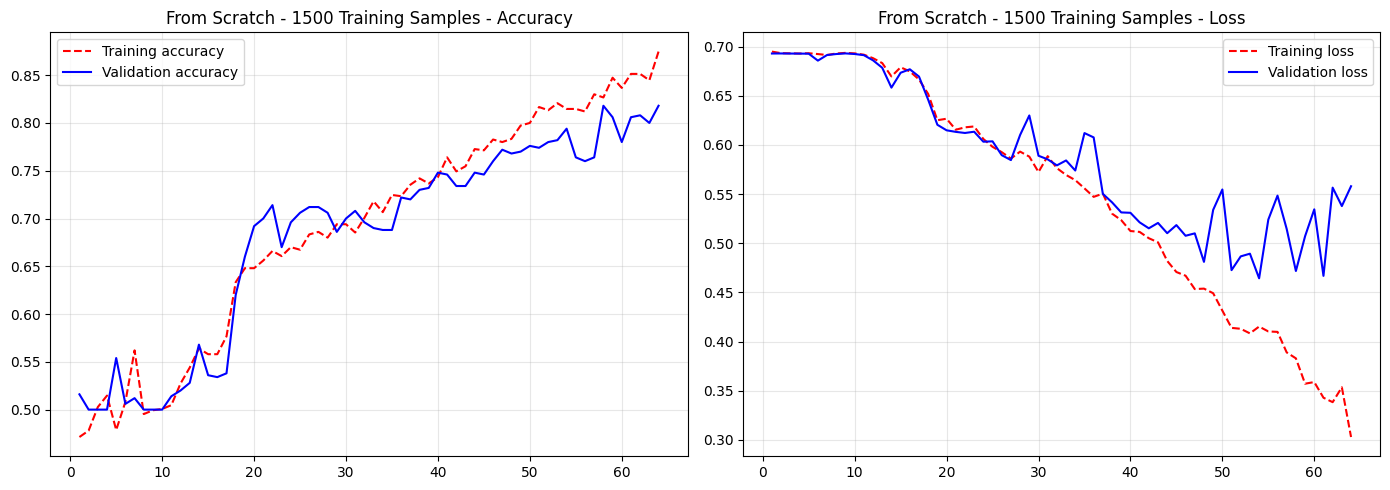


Final Results (Scratch, Train Size 1500): Test Accuracy = 0.7660

==================== Starting Scratch Training with 2000 samples ====================
Training from scratch with an experimental set of 1000 samples per class
Created experimental training set with 1000 images per class.
Found 2000 files belonging to 2 classes.


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,569,089 (5.99 MB)

 Trainable params: 1,569,089 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

Starting training for scratch_train_1000...
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 515ms/step - accuracy: 0.5145 - loss: 0.6988 - val_accuracy: 0.5040 - val_loss: 0.6920
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step - accuracy: 0.5365 - loss: 0.6903 - val_accuracy: 0.5560 - val_loss: 0.6841
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.5550 - loss: 0.6800 - val_accuracy: 0.6120 - val_loss: 0.6607
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.5875 - loss: 0.6678 - val_accuracy: 0.6320 - val_loss: 0.6379
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.6155 - loss: 0.6494 - val_accuracy: 0.6500 - val_loss: 0.6344
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step - accuracy: 0.6170 - loss: 0.6532 - val_accuracy: 0.6540 - val_loss: 0.6390
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.6200 - loss: 0.6512 - val_accuracy: 0.6320 - val_loss: 0.6444
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 320

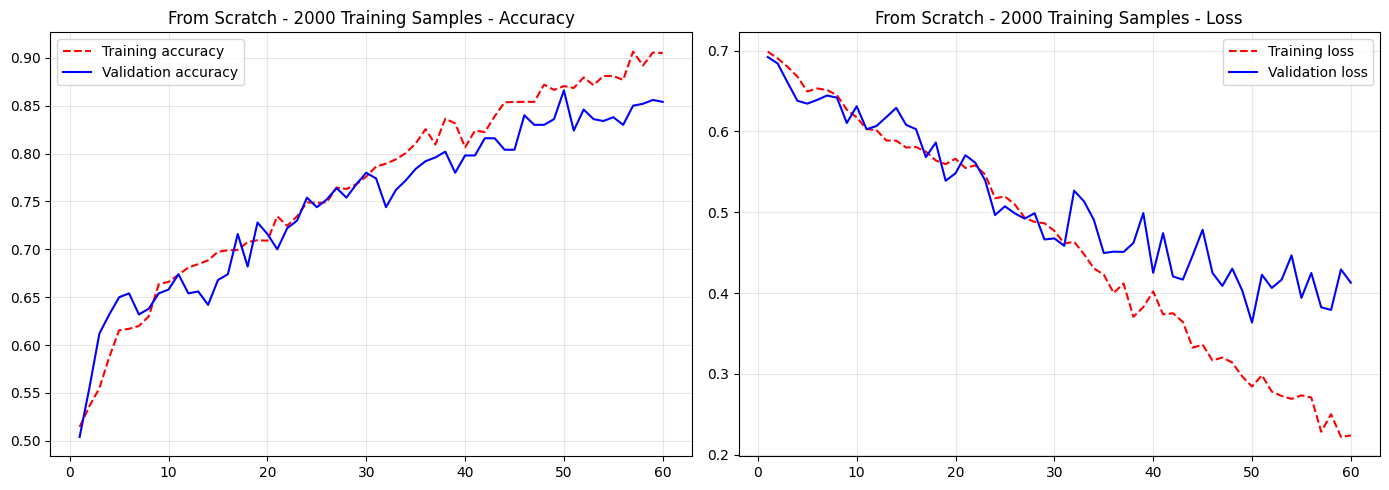


Final Results (Scratch, Train Size 2000): Test Accuracy = 0.8460


In [5]:
scratch_results = []
experimental_train_sizes = [500, 750, 1000] # 1000, 1500, 2000 total training images



for train_size in experimental_train_sizes:
    print(f"\n{'='*20} Starting Scratch Training with {train_size*2} samples {'='*20}")
    print(f"Training from scratch with an experimental set of {train_size} samples per class")

    experimental_train_dir = pathlib.Path(f"experimental_train_{train_size}")

    create_experimental_training_set(source_train_dir, experimental_train_dir, train_size) #


    train_dataset = image_dataset_from_directory(
        experimental_train_dir,
        image_size=image_size,
        batch_size=batch_size
    )


    model_scratch = build_scratch_model(input_shape=(180, 180, 3)) #
    model_scratch.summary()


    prefetched_train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


    results_scratch = train_and_evaluate(
        model=model_scratch,
        train_dataset=prefetched_train_dataset,
        val_dataset=validation_dataset,
        test_dataset=test_dataset,
        model_name=f"scratch_train_{train_size}",
        epochs=100
    )


    plot_training_history(results_scratch["history"], f"From Scratch - {train_size*2} Training Samples")
    scratch_results.append({
        "train_size": train_size * 2,
        "val_accuracy": max(results_scratch["history"].get("val_accuracy", [0])),
        "test_accuracy": results_scratch["test_accuracy"]
    })
    print(f"\nFinal Results (Scratch, Train Size {train_size*2}): Test Accuracy = {results_scratch['test_accuracy']:.4f}")


 Starting Pretrained Xception with 1000 samples 
Using pretrained Xception model with an experimental set of 500 samples per class
Found 1000 files belonging to 2 classes.

Building model for Phase 1 (Frozen Base)...


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_converter                 │ (None, 180, 180, 3)    │             0 │
│ (ImageConverter)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 6, 6, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,331,753 (81.37 MB)

 Non-trainable params: 54,528 (213.00 KB)


Phase 1: Training with frozen base...
Starting training for pretrained_frozen_xception_train_500...
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 187s 4s/step - accuracy: 0.8580 - loss: 0.3240 - val_accuracy: 0.9260 - val_loss: 0.9085
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9360 - loss: 0.1573 - val_accuracy: 0.7900 - val_loss: 2.3162
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9240 - loss: 0.2302 - val_accuracy: 0.7460 - val_loss: 3.8728
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.9420 - loss: 0.1630 - val_accuracy: 0.9020 - val_loss: 0.7400
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9530 - loss: 0.1396 - val_accuracy: 0.9060 - val_loss: 0.5448
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9500 - loss: 0.1156 - val_accuracy: 0.8460 - val_loss: 1.4128
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9680 - loss: 0.1158 - val_accuracy: 0.9100 - val_loss: 0.5735
Epoch 8/30
32/32

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_converter                 │ (None, 180, 180, 3)    │             0 │
│ (ImageConverter)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 6, 6, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,277,225 (81.17 MB)

 Non-trainable params: 109,056 (426.00 KB)

Starting training for pretrained_finetuned_xception_train_500...
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9870 - loss: 0.0343 - val_accuracy: 0.9660 - val_loss: 0.1387
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.9940 - loss: 0.0191 - val_accuracy: 0.9600 - val_loss: 0.1326
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9920 - loss: 0.0242 - val_accuracy: 0.9620 - val_loss: 0.1379
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9900 - loss: 0.0309 - val_accuracy: 0.9500 - val_loss: 0.1532
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9930 - loss: 0.0161 - val_accuracy: 0.9580 - val_loss: 0.1317
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9930 - loss: 0.0182 - val_accuracy: 0.9620 - val_loss: 0.1267
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9960 - loss: 0.0099 - val_accuracy: 0.9600 - val_loss: 0.1283
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - a

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 318 variables whereas the saved optimizer has 158 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best model loaded successfully.
Evaluating pretrained_finetuned_xception_train_500 on test data...
Evaluation complete for pretrained_finetuned_xception_train_500.


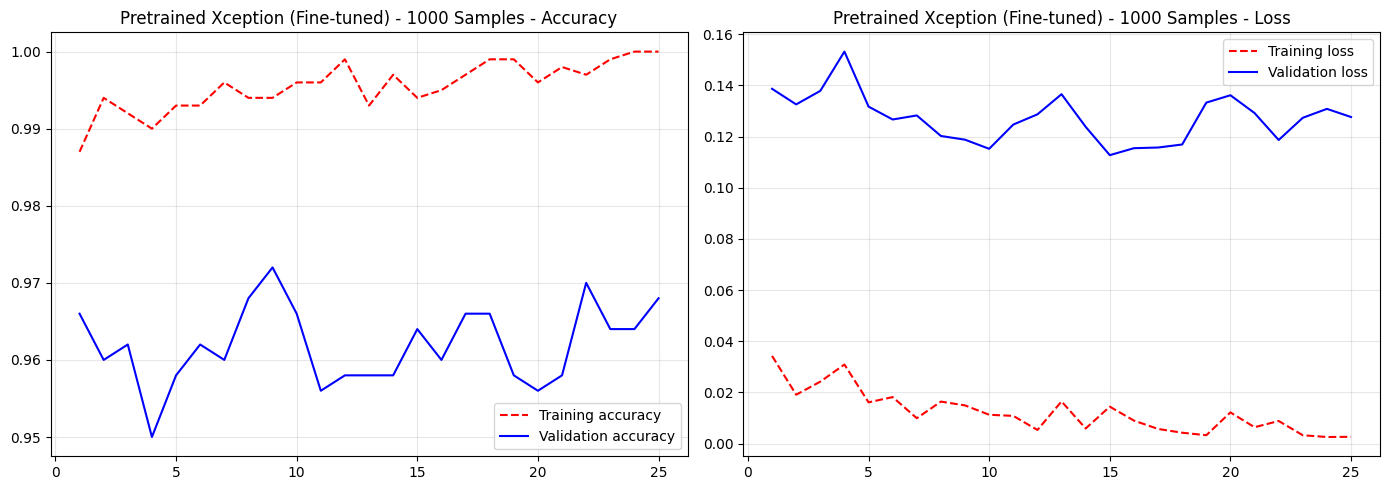


Final Results (Fine-tuned Xception, Train Size 1000): Test Accuracy = 0.9500

 Starting Pretrained Xception with 1500 samples 
Using pretrained Xception model with an experimental set of 750 samples per class
Found 1500 files belonging to 2 classes.

Building model for Phase 1 (Frozen Base)...


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_converter                 │ (None, 180, 180, 3)    │             0 │
│ (ImageConverter)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 6, 6, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,331,753 (81.37 MB)

 Non-trainable params: 54,528 (213.00 KB)


Phase 1: Training with frozen base...
Starting training for pretrained_frozen_xception_train_750...
Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.8920 - loss: 0.2637 - val_accuracy: 0.8960 - val_loss: 1.2999
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9307 - loss: 0.1826 - val_accuracy: 0.9080 - val_loss: 0.7356
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.9487 - loss: 0.1678 - val_accuracy: 0.9220 - val_loss: 0.4001
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.9593 - loss: 0.1302 - val_accuracy: 0.9040 - val_loss: 0.7902
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.9707 - loss: 0.0903 - val_accuracy: 0.9640 - val_loss: 0.1033
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.9693 - loss: 0.0870 - val_accuracy: 0.9420 - val_loss: 0.5019
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9773 - loss: 0.0726 - val_accuracy: 0.9460 - val_loss: 0.2237
Epoch 8/30

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_converter                 │ (None, 180, 180, 3)    │             0 │
│ (ImageConverter)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 6, 6, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,277,225 (81.17 MB)

 Non-trainable params: 109,056 (426.00 KB)

Starting training for pretrained_finetuned_xception_train_750...
Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9780 - loss: 0.0594 - val_accuracy: 0.9640 - val_loss: 0.0846
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9860 - loss: 0.0393 - val_accuracy: 0.9620 - val_loss: 0.0856
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9880 - loss: 0.0272 - val_accuracy: 0.9640 - val_loss: 0.0881
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9887 - loss: 0.0380 - val_accuracy: 0.9620 - val_loss: 0.0815
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9887 - loss: 0.0338 - val_accuracy: 0.9600 - val_loss: 0.0772
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9907 - loss: 0.0281 - val_accuracy: 0.9640 - val_loss: 0.0806
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9947 - loss: 0.0202 - val_accuracy: 0.9640 - val_loss: 0.0839
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - 

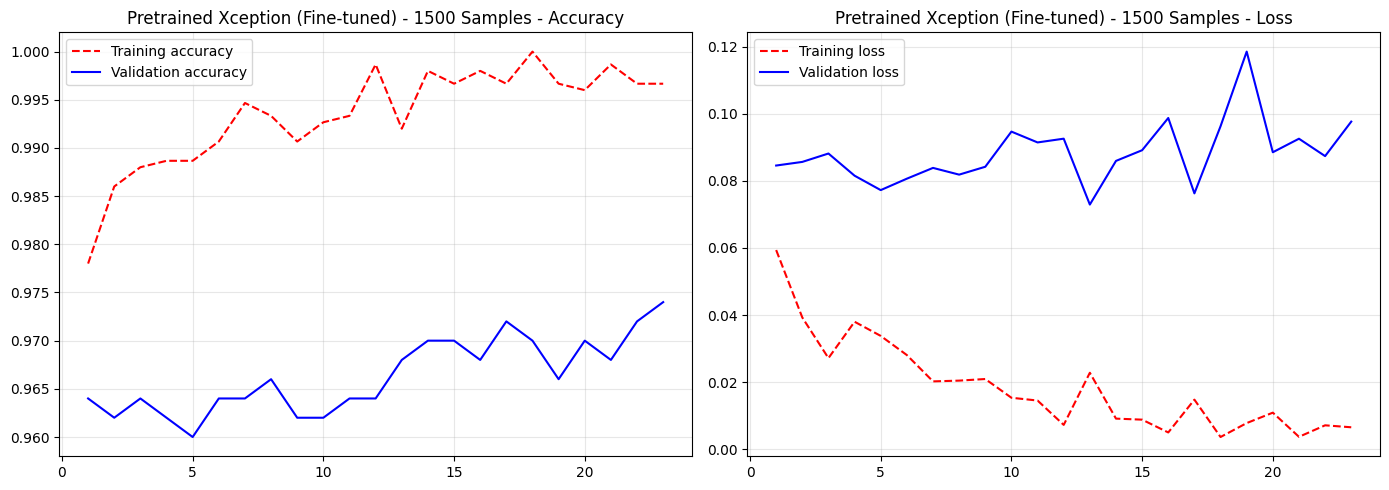


Final Results (Fine-tuned Xception, Train Size 1500): Test Accuracy = 0.9700

 Starting Pretrained Xception with 2000 samples 
Using pretrained Xception model with an experimental set of 1000 samples per class
Found 2000 files belonging to 2 classes.

Building model for Phase 1 (Frozen Base)...


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_converter                 │ (None, 180, 180, 3)    │             0 │
│ (ImageConverter)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 6, 6, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,331,753 (81.37 MB)

 Non-trainable params: 54,528 (213.00 KB)


Phase 1: Training with frozen base...
Starting training for pretrained_frozen_xception_train_1000...
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.8795 - loss: 0.2961 - val_accuracy: 0.6740 - val_loss: 4.8891
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9250 - loss: 0.2140 - val_accuracy: 0.8500 - val_loss: 1.7193
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.9425 - loss: 0.1644 - val_accuracy: 0.9360 - val_loss: 0.2293
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9645 - loss: 0.0986 - val_accuracy: 0.8660 - val_loss: 0.8030
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.9685 - loss: 0.0923 - val_accuracy: 0.9400 - val_loss: 0.2803
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9665 - loss: 0.0988 - val_accuracy: 0.9460 - val_loss: 0.2851
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9760 - loss: 0.0655 - val_accuracy: 0.9440 - val_loss: 0.3207
Epoch 8/3

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_converter                 │ (None, 180, 180, 3)    │             0 │
│ (ImageConverter)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 6, 6, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,277,225 (81.17 MB)

 Non-trainable params: 109,056 (426.00 KB)

Starting training for pretrained_finetuned_xception_train_1000...
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9890 - loss: 0.0337 - val_accuracy: 0.9720 - val_loss: 0.0890
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9910 - loss: 0.0293 - val_accuracy: 0.9720 - val_loss: 0.0909
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9890 - loss: 0.0276 - val_accuracy: 0.9720 - val_loss: 0.0898
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9935 - loss: 0.0195 - val_accuracy: 0.9720 - val_loss: 0.0902
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9935 - loss: 0.0180 - val_accuracy: 0.9700 - val_loss: 0.0971
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9950 - loss: 0.0157 - val_accuracy: 0.9720 - val_loss: 0.0987
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9925 - loss: 0.0145 - val_accuracy: 0.9700 - val_loss: 0.1006
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step -

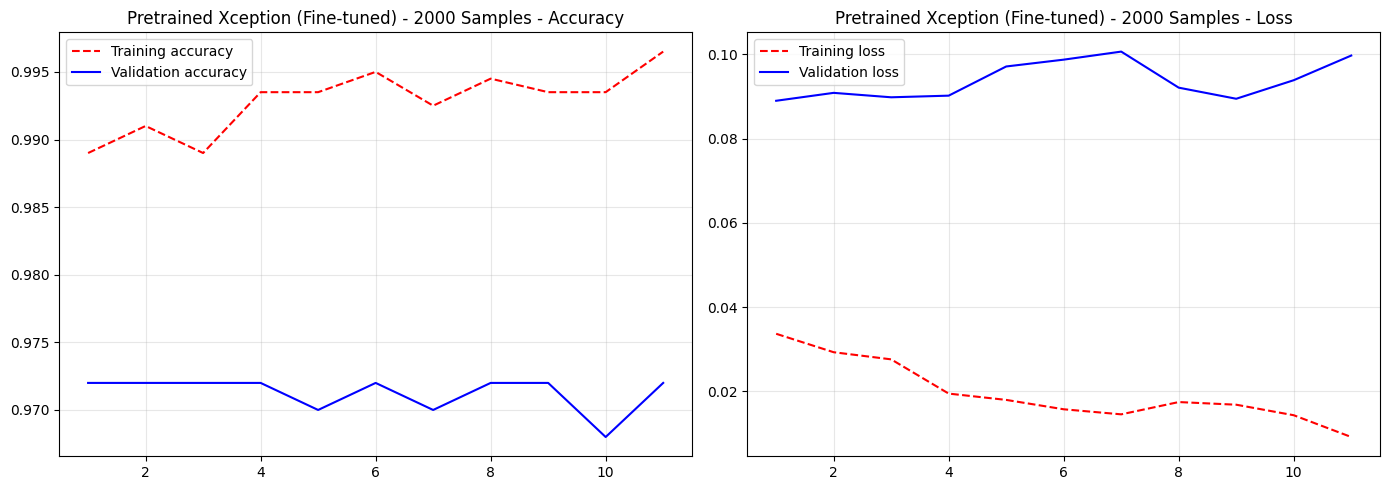


Final Results (Fine-tuned Xception, Train Size 2000): Test Accuracy = 0.9660


In [6]:
pretrained_results = []


for train_size in experimental_train_sizes:
  print(f"\n Starting Pretrained Xception with {train_size*2} samples ")
  print(f"Using pretrained Xception model with an experimental set of {train_size} samples per class")

  experimental_train_dir = pathlib.Path(f"experimental_train_{train_size}")

  if not experimental_train_dir.exists():
         print(f"ERROR: Experimental training set for size {train_size} not found. Run Part 1 first.")
         continue


  train_dataset = image_dataset_from_directory(
        experimental_train_dir,
        image_size=image_size,
        batch_size=batch_size
    )


  print("\nBuilding model for Phase 1 (Frozen Base)...")

  model_frozen, conv_base_frozen = build_pretrained_xception_model(trainable_base=False)
  model_frozen.summary()


  print("\nPhase 1: Training with frozen base...")

  prefetched_train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


  results_frozen = train_and_evaluate(
        model=model_frozen,
        train_dataset=prefetched_train_dataset,
        val_dataset=validation_dataset,
        test_dataset=test_dataset,
        model_name=f"pretrained_frozen_xception_train_{train_size}",
        epochs=30
    )
  print(f"Phase 1 (Frozen Xception) Test Accuracy: {results_frozen['test_accuracy']:.4f}")


  print("\nPhase 2: Fine-tuning Xception...")

  try:

        model_finetune = keras.models.load_model(
            f"pretrained_frozen_xception_train_{train_size}.keras"

            )
        print("Best frozen model loaded successfully for fine-tuning.")
  except Exception as e:
        print(f"Could not load the best frozen model from {f'pretrained_frozen_xception_train_{train_size}'}.keras. Skipping fine-tuning for this size. Error: {e}")
        continue


  try:
        conv_base_finetune = model_finetune.get_layer("xception_backbone")
        conv_base_finetune.trainable = True
        print(f"Xception backbone '{conv_base_finetune.name}' unfrozen.")


        for layer in conv_base_finetune.layers:
           if isinstance(layer, layers.BatchNormalization):
               layer.trainable = False
        print("Batch normalization layers within the backbone frozen for fine-tuning.")

  except ValueError:
        print("Could not find the 'xception_backbone' layer. Check model structure. Skipping fine-tuning.")
        continue



  model_finetune.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        metrics=["accuracy"]
    )
  print("Model recompiled for fine-tuning with low learning rate.")
  model_finetune.summary()

    # Fine-tune the model
  results_finetuned = train_and_evaluate(
        model=model_finetune,
        train_dataset=prefetched_train_dataset,
        val_dataset=validation_dataset,
        test_dataset=test_dataset,
        model_name=f"pretrained_finetuned_xception_train_{train_size}",
        epochs=30
    )


  plot_training_history(
        results_finetuned["history"],
        f"Pretrained Xception (Fine-tuned) - {train_size*2} Samples"
    ) #

  pretrained_results.append({
        "train_size": train_size * 2,
        "val_accuracy": max(results_finetuned["history"].get("val_accuracy", [0])),
        "test_accuracy": results_finetuned["test_accuracy"]
    })
  print(f"\nFinal Results (Fine-tuned Xception, Train Size {train_size*2}): Test Accuracy = {results_finetuned['test_accuracy']:.4f}")


  Scratch Results 
 train_size  val_accuracy  test_accuracy
       1000         0.754          0.718
       1500         0.818          0.766
       2000         0.866          0.846

Pretrained Model  Results 
 train_size  val_accuracy  test_accuracy
       1000         0.972          0.950
       1500         0.974          0.970
       2000         0.972          0.966


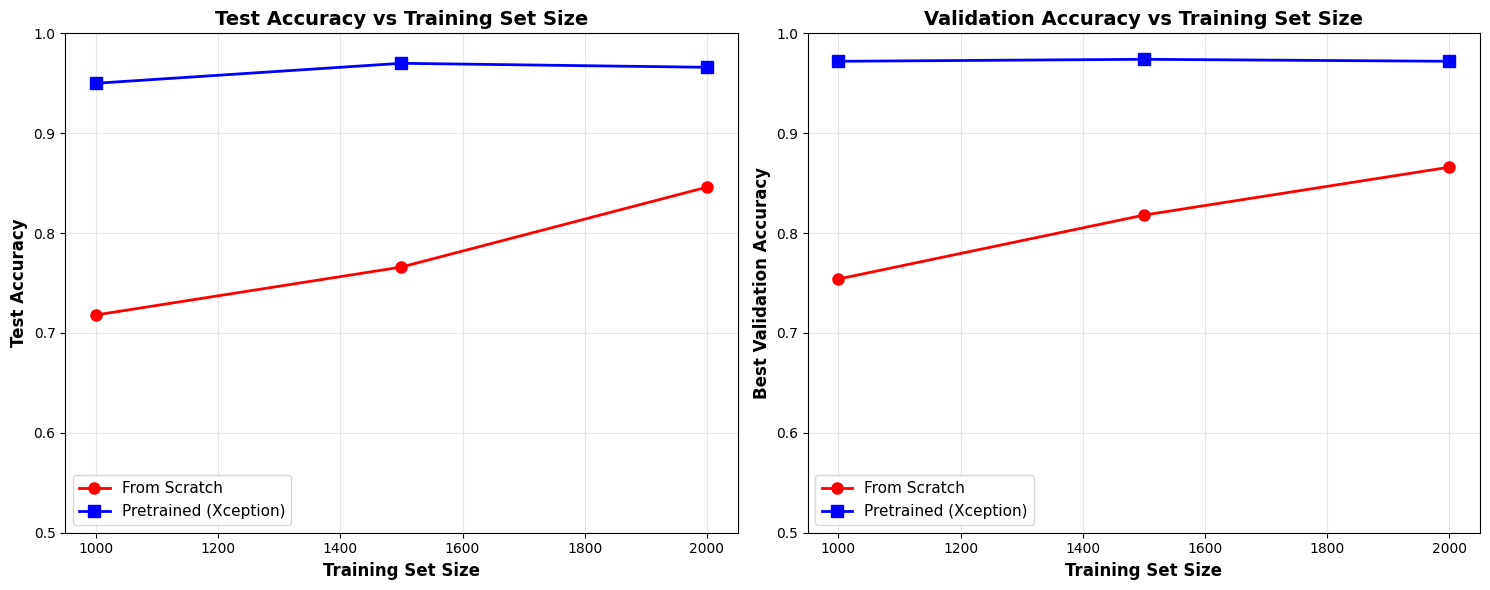


--- Comparison Table (Test Accuracy) ---
 train_size  Scratch Test Acc  Pretrained Test Acc  Improvement
       1000             0.718                0.950        0.232
       1500             0.766                0.970        0.204
       2000             0.846                0.966        0.120
KEY FINDINGS / CONCLUSIONS (Based on this experiment)

Best performance for training from scratch (among sizes tested):
  Training Size: 2000
  Test Accuracy: 0.8460

Best performance for pretrained model (Xception, among sizes tested):
  Training Size: 1500
  Test Accuracy: 0.9700


In [8]:
if 'scratch_results' not in locals() or not scratch_results:
    print("\nScratch results not found. Please run Part 1.")
    df_scratch = pd.DataFrame(columns=['train_size', 'val_accuracy', 'test_accuracy'])
else:
    df_scratch = pd.DataFrame(scratch_results)

if 'pretrained_results' not in locals() or not pretrained_results:
     print("Pretrained results not found. Please run Part 2.")
     df_pretrained = pd.DataFrame(columns=['train_size', 'val_accuracy', 'test_accuracy'])
else:
    df_pretrained = pd.DataFrame(pretrained_results)


print("\n  Scratch Results ")
print(df_scratch.to_string(index=False))

print("\nPretrained Model  Results ")
print(df_pretrained.to_string(index=False))


fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Test Accuracy vs Training Size
axes[0].plot(df_scratch['train_size'], df_scratch['test_accuracy'],
             'o-', label='From Scratch', linewidth=2, markersize=8, color='red')
axes[0].plot(df_pretrained['train_size'], df_pretrained['test_accuracy'],
             's-', label='Pretrained (Xception)', linewidth=2, markersize=8, color='blue')
axes[0].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Test Accuracy vs Training Set Size', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0]) # Set y-axis from 50% to 100%

# Plot 2: Validation Accuracy vs Training Size
axes[1].plot(df_scratch['train_size'], df_scratch['val_accuracy'],
             'o-', label='From Scratch', linewidth=2, markersize=8, color='red')
axes[1].plot(df_pretrained['train_size'], df_pretrained['val_accuracy'],
             's-', label='Pretrained (Xception)', linewidth=2, markersize=8, color='blue')
axes[1].set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Best Validation Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Validation Accuracy vs Training Set Size', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('comparison_results_xception_500valtest.png', dpi=300)
plt.show()


comparison_df = pd.merge(
    df_scratch[['train_size', 'test_accuracy']].rename(columns={'test_accuracy': 'Scratch Test Acc'}),
    df_pretrained[['train_size', 'test_accuracy']].rename(columns={'test_accuracy': 'Pretrained Test Acc'}),
    on='train_size',
    how='outer'
)
comparison_df['Improvement'] = (comparison_df['Pretrained Test Acc'] - comparison_df['Scratch Test Acc'])

print("\n--- Comparison Table (Test Accuracy) ---")
print(comparison_df.round(4).to_string(index=False)) #


best_scratch_acc = 0
best_scratch_size = 'N/A'
if not df_scratch.empty:
    best_scratch_idx = df_scratch['test_accuracy'].idxmax()
    best_scratch_acc = df_scratch.loc[best_scratch_idx, 'test_accuracy']
    best_scratch_size = df_scratch.loc[best_scratch_idx, 'train_size']

best_pretrained_acc = 0
best_pretrained_size = 'N/A'
if not df_pretrained.empty:
    best_pretrained_idx = df_pretrained['test_accuracy'].idxmax()
    best_pretrained_acc = df_pretrained.loc[best_pretrained_idx, 'test_accuracy']
    best_pretrained_size = df_pretrained.loc[best_pretrained_idx, 'train_size']



print("KEY FINDINGS / CONCLUSIONS (Based on this experiment)")

print(f"\nBest performance for training from scratch (among sizes tested):")
print(f"  Training Size: {best_scratch_size}")
print(f"  Test Accuracy: {best_scratch_acc:.4f}")

print(f"\nBest performance for pretrained model (Xception, among sizes tested):")
print(f"  Training Size: {best_pretrained_size}")
print(f"  Test Accuracy: {best_pretrained_acc:.4f}")